#S2-23_AIMLCZG530 : Natural Language Processing
##Assigment 2 - Problem Statement 21
###Team Members
1. ADARSH S - 2023AA05811
2. VAIBHAV BAJPAI - 2023AA05631
3. DIVAKAR ROY - 2023AA05721
4. NELLORE VAMSI KIRAN REDDY - 2023AA05240

The goal of this assignment is to introduce Transformers, Encoder Decoder architecture and BERT.<br>
Dataset: [Dialogue Data](https://drive.google.com/file/d/19qL50jRgtvqpp28uJZn8sTc-iHkGgtCb/view?usp=drive_link)

###Part 1 : Preprocessing the data

####Reading the dataset, lowercasing and EDA

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import spacy
from transformers import BertTokenizer, BertModel

D:\BITS\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# loading with csv library since there are issues in the file
# data = []
# with open('DiaglougeData.csv', 'r', encoding='utf-8') as file:
#     reader = csv.reader(file)
#     for row in reader:
#         data.append(row)
# dialogue_df = pd.DataFrame(data[1:], columns=data[0])
dialogue_df = pd.read_csv(r"DiaglougeData.csv")

In [ ]:
dialogue_df.head()

,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...
1,13729565,Eric: MACHINE!\nRob: That's so gr8!\nEric: I k...,Eric and Rob are going to watch a stand-up on ...
2,13680171,"Lenny: Babe, can you help me with something?\n...",Lenny can't decide which trousers to buy. Bob ...
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...
4,13828600,"Ollie: Hi , are you in Warsaw\nJane: yes, just...",Jane is in Warsaw. Ollie and Jane has a party....


In [ ]:
dialogue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1815 non-null   object
 1   dialogue  1815 non-null   object
 2   summary   1815 non-null   object
dtypes: object(3)
memory usage: 42.7+ KB


In [ ]:
print(dialogue_df.isnull().sum())

id          0
dialogue    0
summary     0
dtype: int64


In [ ]:
dialogue_df = dialogue_df.dropna()

In [ ]:
# convert text to lowercase
dialogue_df['dialogue'] = dialogue_df['dialogue'].str.lower()
dialogue_df['summary'] = dialogue_df['summary'].str.lower()
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9?.!,\s]', '', text)
    return text
# clean text- only alphanumeric and punctuation
dialogue_df['dialogue'] = dialogue_df['dialogue'].apply(clean_text)
dialogue_df['summary'] = dialogue_df['summary'].apply(clean_text)

In [ ]:
df = dialogue_df.copy()

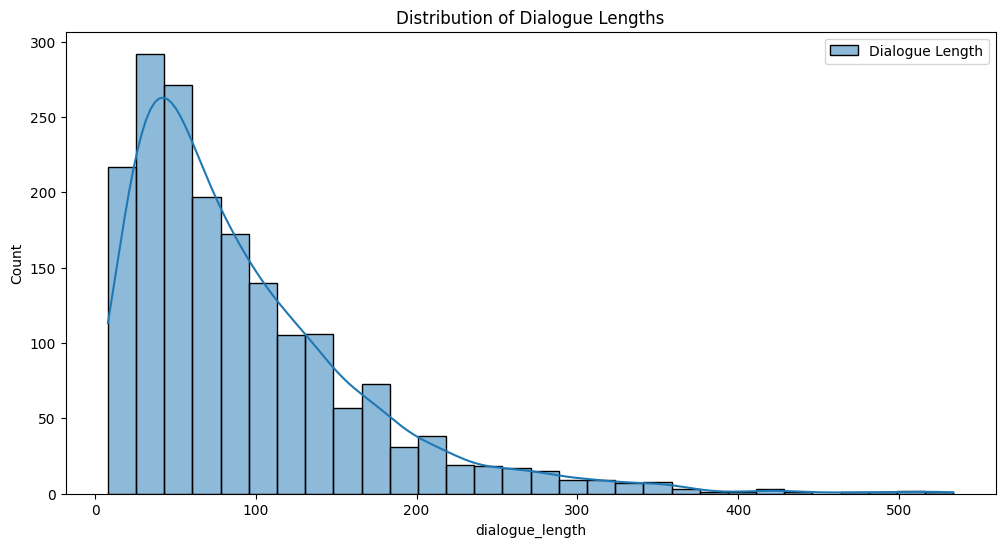

In [ ]:
# Length of dialogues and summaries
df['dialogue_length'] = df['dialogue'].apply(lambda x: len(x.split()))
df['summary_length'] = df['summary'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df['dialogue_length'], bins=30, kde=True, label='Dialogue Length')
plt.legend()
plt.title('Distribution of Dialogue Lengths')
plt.show()

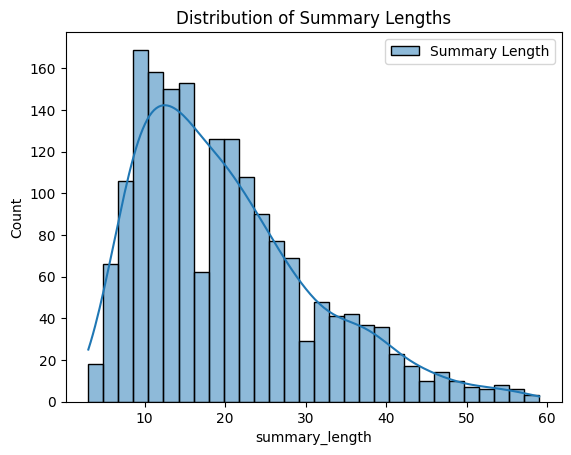

In [ ]:
sns.histplot(df['summary_length'], bins=30, kde=True, label='Summary Length')
plt.legend()
plt.title('Distribution of Summary Lengths')
plt.show()

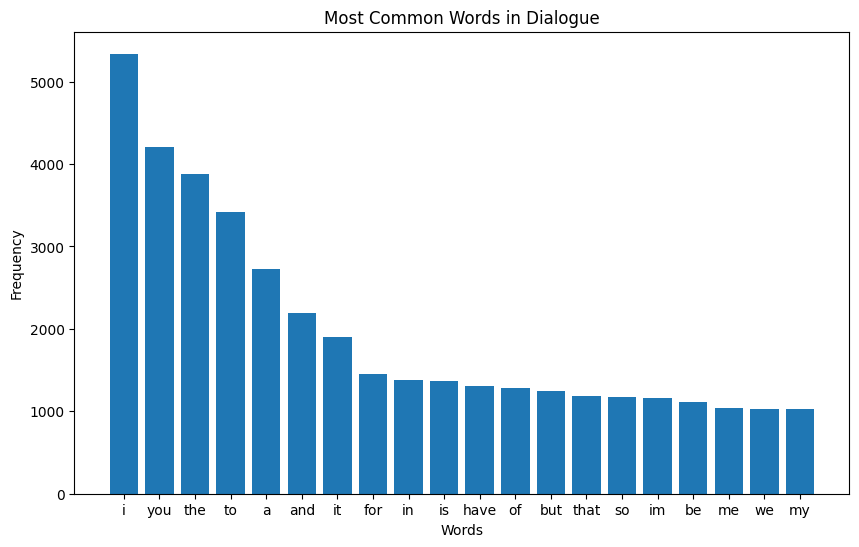

In [ ]:
# split all dialogues into words and get the count
all_words = ' '.join(df['dialogue']).split()
common_words = Counter(all_words).most_common(20)
words, counts = zip(*common_words)
# bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words in Dialogue')
plt.show()

####Tokenization, Encoding and Text vectorization

In [ ]:
# load the SpaCy english model
nlp = spacy.load('en_core_web_sm')

# tokenize using SpaCy english model
def spacy_tokenizer(text):
    return [token.text for token in nlp(text)]

# build vocabulary
def build_vocab(token_lists, min_freq=1):
    token_counter = Counter(token for tokens in token_lists for token in tokens)
    vocab = {token: idx+2 for idx, (token, freq) in enumerate(token_counter.items()) if freq >= min_freq}
    vocab['<PAD>'] = 0  # Padding token
    vocab['<UNK>'] = 1  # Unknown token
    return vocab

# apply tokenizer to the dataframe
df['dialogue_tokens'] = df['dialogue'].apply(spacy_tokenizer)
df['summary_tokens'] = df['summary'].apply(spacy_tokenizer)

# build vocabularies for dialogues and summaries
dialogue_vocab = build_vocab(df['dialogue_tokens'])
summary_vocab = build_vocab(df['summary_tokens'])

In [ ]:
len(dialogue_vocab), len(summary_vocab)

In [ ]:
summary_vocab_inv = {v: k for k, v in summary_vocab.items()}

####Extract features and labels

In [ ]:
# convert tokens to integer sequences
def tokens_to_ids(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

# encode dialogue and summary tokens to integer sequences
df['dialogue_ids'] = df['dialogue_tokens'].apply(lambda tokens: tokens_to_ids(tokens, dialogue_vocab))
df['summary_ids'] = df['summary_tokens'].apply(lambda tokens: tokens_to_ids(tokens, summary_vocab))

# maximum lengths for dialogue and summary
max_dialogue_length = max(df['dialogue_ids'].apply(len))
max_summary_length = max(df['summary_ids'].apply(len))

# pad sequences for consistent length
df['dialogue_padded'] = df['dialogue_ids'].apply(lambda x: x[:max_dialogue_length] + [dialogue_vocab['<PAD>']] * (max_dialogue_length - len(x)))
df['summary_padded'] = df['summary_ids'].apply(lambda x: x[:max_summary_length] + [summary_vocab['<PAD>']] * (max_summary_length - len(x)))

In [ ]:
max(df['dialogue_ids'].apply(lambda x: max(x))), max(df['summary_ids'].apply(lambda x:max(x)))

###Part 2 : Encoder-Decoder model

In [ ]:
# split the data into train and test sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# custom class for the Dialogue Dataset
class DialogueDataset(Dataset):
    def __init__(self, dialogues, summaries):
        self.dialogues = dialogues
        self.summaries = summaries

    def __len__(self):
        return len(self.dialogues)

    def __getitem__(self, idx):
        return torch.tensor(self.dialogues.iloc[idx]), torch.tensor(self.summaries.iloc[idx])

In [ ]:
# create dataLoader for train and val
train_dataset = DialogueDataset(train_data['dialogue_padded'], train_data['summary_padded'])
val_dataset = DialogueDataset(val_data['dialogue_padded'], val_data['summary_padded'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# LSTM based Encoder-Decoder model
class LSTMEncoderDecoderModel(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim, hidden_dim):
        super(LSTMEncoderDecoderModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, src, tgt):
        embedded_src = self.embedding(src)
        encoder_outputs, (hidden, cell) = self.encoder(embedded_src)
        embedded_tgt = self.embedding(tgt)
        decoder_outputs, _ = self.decoder(embedded_tgt, (hidden, cell))
        output = self.fc(decoder_outputs)
        return output

In [ ]:
# define a function for evaluating the model on validation data
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    total_val_acc = 0
    with torch.no_grad():
        for batch_idx, (dialogues, summaries) in enumerate(val_loader):
            dialogues, summaries = dialogues.to(device), summaries.to(device)
            output = model(dialogues, summaries)
            output = output.view(-1, output_dim)
            summaries = summaries.view(-1)
            loss = criterion(output, summaries)
            total_val_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            non_pad_elements = (summaries != dialogue_vocab['<PAD>'])
            correct = preds.eq(summaries).masked_select(non_pad_elements).sum().item()
            total = non_pad_elements.sum().item()
            acc = correct / total if total > 0 else 0
            total_val_acc += acc
    avg_loss = total_val_loss / len(val_loader)
    avg_acc = total_val_acc / len(val_loader)
    return avg_loss, avg_acc

In [ ]:
# define parameters
input_dim = len(dialogue_vocab)
output_dim = len(summary_vocab)
embed_dim = 128
hidden_dim = 256
no_of_epochs = 10
# instantiate the model, define loss function and optimizer
lstm_model = LSTMEncoderDecoderModel(input_dim, output_dim, embed_dim, hidden_dim)
criterion = nn.CrossEntropyLoss(ignore_index=dialogue_vocab['<PAD>'])
optimizer = optim.Adam(lstm_model.parameters())

In [ ]:
# training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)

for epoch in range(no_of_epochs):
    lstm_model.train()
    total_train_loss = 0
    total_train_acc = 0
    for batch_idx, (dialogues, summaries) in enumerate(train_loader):
        dialogues, summaries = dialogues.to(device), summaries.to(device)
        optimizer.zero_grad()
        output = lstm_model(dialogues, summaries)
        # Reshape for loss function
        output = output.view(-1, output_dim)
        summaries = summaries.view(-1)
        loss = criterion(output, summaries)
        loss.backward()
        optimizer.step()
        # Get the predicted token by taking the argmax over the output probabilities
        preds = torch.argmax(output, dim=1)
        # Create a mask to ignore the padding tokens in the target
        non_pad_elements = (summaries != dialogue_vocab['<PAD>'])
        # Calculate accuracy by comparing predicted and target tokens
        correct = preds.eq(summaries).masked_select(non_pad_elements).sum().item()
        total = non_pad_elements.sum().item()
        acc = correct / total if total > 0 else 0
        total_train_loss += loss
        total_train_acc += acc
    # Average training loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)
    print(f'Epoch: {epoch}\nTraining Loss: {avg_train_loss}, Training Accuracy: {avg_train_acc}')
    # Validation step
    val_loss, val_acc = evaluate(lstm_model, val_loader, criterion, device)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

print("Training complete.")

Epoch: 0
Training Loss: 6.452574253082275, Training Accuracy: 0.2334843862912179
Validation Loss: 5.0145706335703535, Validation Accuracy: 0.39954118743117384
Epoch: 1
Training Loss: 4.131836891174316, Training Accuracy: 0.4810900613477449
Validation Loss: 3.7812601725260415, Validation Accuracy: 0.5577497851911325
Epoch: 2
Training Loss: 3.062596321105957, Training Accuracy: 0.6249514322311045
Validation Loss: 3.056633730729421, Validation Accuracy: 0.6756933342064158
Epoch: 3
Training Loss: 2.3373188972473145, Training Accuracy: 0.725771908746153
Validation Loss: 2.5594690243403115, Validation Accuracy: 0.7460601656021538
Epoch: 4
Training Loss: 1.8015822172164917, Training Accuracy: 0.7938884604619225
Validation Loss: 2.201528310775757, Validation Accuracy: 0.7936640052527678
Epoch: 5
Training Loss: 1.3965619802474976, Training Accuracy: 0.843320125403313
Validation Loss: 1.9555159111817677, Validation Accuracy: 0.8215621389444375
Epoch: 6
Training Loss: 1.0832453966140747, Training

In [ ]:

# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding)
        return hidden, cell

# Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding, (hidden, cell))
        predictions = self.fc(outputs).squeeze(1)
        return predictions, hidden, cell

# Define Seq2Seq model class
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        hidden, cell = self.encoder(source)

        x = target[:, 0]  # <sos> token as initial input
        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            x = target[:, t] if teacher_force else top1
        return outputs

def accuracy_fn(predictions, targets):
    pred_tokens = predictions.argmax(dim=2)  # Get the predicted tokens (batch_size, seq_len)
    correct = (pred_tokens == targets).float()  # Compare with targets (batch_size, seq_len)
    acc = correct.sum() / correct.numel()  # Calculate accuracy
    return acc

def evaluate(model, criterion, data_loader, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for source, target in data_loader:
            source = source.to(device)
            target = target.to(device)

            outputs = model(source, target, teacher_forcing_ratio=0)  # no teacher forcing during evaluation

            # Accuracy calculation before reshaping
            acc = accuracy_fn(outputs, target)  # Original output shape (batch_size, seq_len, vocab_size)
            epoch_acc += acc.item()

            # Loss calculation
            outputs = outputs[:, 1:].reshape(-1, outputs.shape[-1])  # Flatten for loss calculation
            target = target[:, 1:].reshape(-1)
            loss = criterion(outputs, target)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)


def train(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0

        for source, target in train_loader:
            source = source.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(source, target)

            # Accuracy calculation before reshaping
            acc = accuracy_fn(outputs, target)  # Original output shape (batch_size, seq_len, vocab_size)
            train_acc += acc.item()

            # Loss calculation
            outputs = outputs[:, 1:].reshape(-1, outputs.shape[-1])  # Flatten for loss calculation
            target = target[:, 1:].reshape(-1)
            loss = criterion(outputs, target)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loss and accuracy after each epoch
        val_loss, val_acc = evaluate(model, criterion, val_loader, device)

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Training Loss: {train_loss / len(train_loader):.4f}, Training Accuracy: {train_acc / len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(dialogue_vocab)  # Vocabulary size for dialogues
output_size = len(summary_vocab)  # Vocabulary size for summaries
embedding_size = 256
hidden_size = 512
num_layers = 1
batch_size = 32
learning_rate = 0.001

# Instantiate encoder, decoder, and Seq2Seq model
encoder = Encoder(input_size, embedding_size, hidden_size, num_layers).to(device)
decoder = Decoder(output_size, embedding_size, hidden_size, num_layers).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Padding index should be ignored
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Assuming DataLoader objects `train_loader` and `val_loader` are created as before
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Start training
train(model, criterion, optimizer, train_loader, val_loader, device, epochs=10)


Epoch [1/10]
Training Loss: 6.8411, Training Accuracy: 0.0272
Validation Loss: 6.4686, Validation Accuracy: 0.0353
Epoch [2/10]
Training Loss: 6.1161, Training Accuracy: 0.0352
Validation Loss: 6.4994, Validation Accuracy: 0.0354
Epoch [3/10]
Training Loss: 5.9412, Training Accuracy: 0.0410
Validation Loss: 6.5414, Validation Accuracy: 0.0358
Epoch [4/10]
Training Loss: 5.7723, Training Accuracy: 0.0443
Validation Loss: 6.5845, Validation Accuracy: 0.0356
Epoch [5/10]
Training Loss: 5.6333, Training Accuracy: 0.0455
Validation Loss: 6.6414, Validation Accuracy: 0.0346
Epoch [6/10]
Training Loss: 5.5496, Training Accuracy: 0.0453
Validation Loss: 6.6755, Validation Accuracy: 0.0339


###Part 3 : BERT

In [ ]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# tokenization function using BERT
def bert_tokenizer(text, max_length=100):
    tokens = tokenizer.encode_plus(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,  # Add [CLS] and [SEP]
        return_tensors='pt'       # Return PyTorch tensors
    )
    return tokens['input_ids'], tokens['attention_mask']

In [ ]:
# apply BERT tokenizer to dialogues and summaries
df['dialogue_input_ids'], df['dialogue_attention_mask'] = zip(*df['dialogue'].apply(lambda x: bert_tokenizer(x, max_length=250)))
df['summary_input_ids'], df['summary_attention_mask'] = zip(*df['summary'].apply(lambda x: bert_tokenizer(x, max_length=50)))

In [ ]:
class DialogueDatasetBERT(Dataset):
    def __init__(self, dialogues, summaries, dialogue_masks, summary_masks):
        self.dialogues = dialogues
        self.summaries = summaries
        self.dialogue_masks = dialogue_masks
        self.summary_masks = summary_masks

    def __len__(self):
        return len(self.dialogues)

    def __getitem__(self, idx):
        return {
            'dialogue': self.dialogues.iloc[idx].squeeze(0),
            'summary': self.summaries.iloc[idx].squeeze(0),
            'dialogue_mask': self.dialogue_masks.iloc[idx].squeeze(0),
            'summary_mask': self.summary_masks.iloc[idx].squeeze(0)
        }

In [ ]:
class BERTTransformerDecoderModel(nn.Module):
    def __init__(self, bert_model, output_dim, hidden_dim, nhead, num_decoder_layers, max_length, pad_token_id):
        super(BERTTransformerDecoderModel, self).__init__()
        self.bert = bert_model
        self.pad_token_id = pad_token_id
        # Linear projection to match BERT output (768) to hidden_dim (512)
        self.projection_layer = nn.Linear(bert_model.config.hidden_size, hidden_dim)
        # Embedding for decoder input
        self.embedding = nn.Embedding(output_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, hidden_dim))
        # Transformer decoder
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_dim, nhead=nhead),
            num_layers=num_decoder_layers
        )
        # Linear layer to map hidden states to vocabulary
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, dialogue_ids, dialogue_mask, summary_ids):
        # Get BERT embeddings for dialogue (Encoder)
        with torch.no_grad():
          bert_outputs = self.bert(input_ids=dialogue_ids, attention_mask=dialogue_mask)
          encoder_outputs = bert_outputs.last_hidden_state
        # Project BERT's hidden size to the decoder's expected hidden size (512)
        encoder_outputs = self.projection_layer(encoder_outputs)
        # Get summary embeddings (Decoder input)
        summary_embeddings = self.embedding(summary_ids) + self.positional_encoding[:, :summary_ids.size(1), :]
        # Generate attention mask for the summary (to prevent attending to future tokens)
        tgt_mask = self.generate_square_subsequent_mask(summary_ids.size(1)).to(summary_ids.device)
        # Convert dialogue_mask to a boolean type
        dialogue_mask_bool = (dialogue_mask == self.pad_token_id)  # Use pad_token_id for boolean mask
        # Pass through Transformer decoder
        decoder_outputs = self.transformer_decoder(
            summary_embeddings.transpose(0, 1),  # (seq_len, batch_size, embed_dim)
            encoder_outputs.transpose(0, 1),     # (seq_len, batch_size, embed_dim)
            tgt_mask=tgt_mask,
            memory_key_padding_mask=dialogue_mask_bool  # Transformer expects boolean mask
        )
        # Final output layer to map to vocabulary
        output = self.fc(decoder_outputs.transpose(0, 1))  # (batch_size, seq_len, output_dim)
        return output

    def generate_square_subsequent_mask(self, sz):
        """Generate a mask to prevent attention to future tokens in the decoder."""
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask


In [ ]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# create dataLoader
train_dataset = DialogueDatasetBERT(
    train_data['dialogue_input_ids'],
    train_data['summary_input_ids'],
    train_data['dialogue_attention_mask'],
    train_data['summary_attention_mask']
)
val_dataset = DialogueDatasetBERT(
    val_data['dialogue_input_ids'],
    val_data['summary_input_ids'],
    val_data['dialogue_attention_mask'],
    val_data['summary_attention_mask']
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:
# Define parameters
hidden_dim = 512
nhead = 8
num_decoder_layers = 6
no_of_epochs = 10
output_dim = tokenizer.vocab_size  # Vocabulary size for the summary
max_length = 50  # Maximum length of the summary
pad_token_id = tokenizer.pad_token_id
bert_transformer_model = BERTTransformerDecoderModel(bert_model, output_dim, hidden_dim, nhead, num_decoder_layers, max_length, pad_token_id)
bert_transformer_model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
optimizer = optim.Adam(bert_transformer_model.parameters(), lr=1e-4)

In [ ]:
# model training
for epoch in range(no_of_epochs):
    bert_transformer_model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_tokens = 0
    for batch in train_loader:
        dialogues = batch['dialogue'].to(device)
        dialogue_masks = batch['dialogue_mask'].to(device)
        summaries = batch['summary'].to(device)
        summary_masks = batch['summary_mask'].to(device)
        optimizer.zero_grad()
        output = bert_transformer_model(dialogues, dialogue_masks, summaries)
        output = output[:, :summaries.shape[1], :]
        batch_size, seq_len, _ = output.shape
        output = output.reshape(-1, output_dim)
        summaries = summaries.reshape(-1)
        # Mask out padding tokens in loss computation
        valid_indices = summaries != tokenizer.pad_token_id
        output = output[valid_indices]
        summaries = summaries[valid_indices]
        loss = criterion(output, summaries)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(output, dim=-1)
        correct_train_predictions += (preds == summaries).sum().item()
        total_train_tokens += valid_indices.sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct_train_predictions / total_train_tokens  # Training accuracy
    print(f'Epoch: {epoch}\nTraining Loss: {train_loss}\nTraining Accuracy: {train_acc}')
    # Validation
    bert_transformer_model.eval()
    val_loss = 0.0
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_tokens = 0
    with torch.no_grad():
        for batch in val_loader:
            dialogues = batch['dialogue'].to(device)
            dialogue_masks = batch['dialogue_mask'].to(device)
            summaries = batch['summary'].to(device)
            summary_masks = batch['summary_mask'].to(device)
            output = bert_transformer_model(dialogues, dialogue_masks, summaries)
            output = output[:, :summaries.shape[1], :]
            batch_size, seq_len, _ = output.shape
            output = output.reshape(-1, output_dim)
            summaries = summaries.reshape(-1)
            # mask out padding tokens in loss computation
            valid_indices = summaries != tokenizer.pad_token_id
            output = output[valid_indices]
            summaries = summaries[valid_indices]
            loss = criterion(output, summaries)
            val_loss += loss.item()
            preds = torch.argmax(output, dim=-1)
            correct_val_predictions += (preds == summaries).sum().item()
            total_val_tokens += valid_indices.sum().item()
    val_loss = val_loss / len(val_loader)
    val_acc = correct_val_predictions / total_val_tokens  # Validation accuracy
    print(f'Validation Loss: {val_loss}\nValidation Accuracy: {val_acc}')
print("Training complete")

Epoch: 0
Training Loss: 4.592850125752962
Training Accuracy: 0.555978374973756
Validation Loss: 2.926407990248307
Validation Accuracy: 0.7104282115869017
Epoch: 1
Training Loss: 2.181958021043421
Training Accuracy: 0.7767425992021835
Validation Loss: 2.072471051112465
Validation Accuracy: 0.8110831234256927
Epoch: 2
Training Loss: 1.4247269810556056
Training Accuracy: 0.8652634893974386
Validation Loss: 1.6801421564558279
Validation Accuracy: 0.853198992443325
Epoch: 3
Training Loss: 0.9970573910645076
Training Accuracy: 0.9152319966407726
Validation Loss: 1.4423970606016077
Validation Accuracy: 0.8787909319899244
Epoch: 4
Training Loss: 0.7057819659565832
Training Accuracy: 0.9492704178039051
Validation Loss: 1.2962378807689832
Validation Accuracy: 0.9034760705289673
Epoch: 5
Training Loss: 0.5020626599972065
Training Accuracy: 0.9833613268948141
Validation Loss: 1.1780067578605984
Validation Accuracy: 0.9232241813602015
Epoch: 6
Training Loss: 0.34936521104076407
Training Accuracy: 0

###Prediction and Evaluation

In [ ]:
dialogue_text = """
Kris: Hey! Does anyone here listen to podcasts?
Leigh: Sure!
Sam: Not really, but thinking about it.
Kris: Gr8! Leigh, tell me. Where do u get them from?
Leigh: What do u mean?
Kris: Do u have a website or something?
Leigh: I have an app. It's called PodCasts. Don't u have one?
Sam: iPhone?
Leigh: Yes :)
Kris: Okay. Need to find some podcasts.
Sam: Y?
Kris: Well, I can't listen to all the ppl talking on the train when I commute.
Leigh: So y not music?
Kris: Not always in the mood for that. If I'm still sleepy, I feel I don't appreciate it enough.
Sam: Depends really on the topic. What are u looking for?
Kris: Well, I like reading, so literature. Interested in social topics, like homelessness and so on. I also like psychology.
Leigh: You should try Mark Gungor!
"""

####LSTM based Encoder-Decoder Model Prediction

In [ ]:
def process_text(text):
  # tokenize the dialogue
  dialogue_tokens = spacy_tokenizer(dialogue_text)
  # convert tokens to integer IDs using the dialogue vocabulary
  dialogue_ids = tokens_to_ids(dialogue_tokens, dialogue_vocab)
  # pad the sequence to the maximum dialogue length
  dialogue_padded = dialogue_ids[:max_dialogue_length] + [dialogue_vocab['<PAD>']] * (max_dialogue_length - len(dialogue_ids))
  return dialogue_padded
# process the text
dialogue_padded = process_text(dialogue_text)
# convert to a tensor for model input
input_tensor = torch.tensor([dialogue_padded]).to(device)
lstm_model.eval()
with torch.no_grad():
    dummy_target = torch.zeros((1, max_summary_length)).long().to(device)
    output = lstm_model(input_tensor, dummy_target)
# convert the output logits to token IDs
predicted_summary_ids = output.argmax(dim=-1).cpu().numpy()[0]
# convert token IDs to text tokens
predicted_summary_tokens = [summary_vocab_inv[id] for id in predicted_summary_ids]
# join tokens to form the predicted summary text
lstm_predicted_summary = ' '.join(predicted_summary_tokens)
print("Predicted Summary:")
print(lstm_predicted_summary)

####BERT Encoder Model Prediction

In [ ]:
def sample_next_token(logits, temperature=1.0):
    logits = logits / temperature
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    return torch.multinomial(probabilities, num_samples=1)
def generate_summary(model, dialogue_text, temperature, max_length=50):
    model.eval()
    # tokenize and encode the dialogue text
    input_ids, attention_mask = bert_tokenizer(dialogue_text)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    # initialize the summary sequence with the start token
    summary_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)  # Using [CLS] as start token
    # generate summary
    with torch.no_grad():
        for _ in range(max_length):
            # Get model output
            output = model(input_ids, attention_mask, summary_ids)
            logits = output[:, -1, :]
            # Get the predicted token IDs with the highest scores
            # predicted_ids = torch.argmax(output[:, -1, :], dim=-1)  # Get the last token in the sequence
            predicted_ids = sample_next_token(logits, temperature=temperature)
            predicted_ids = predicted_ids.squeeze(1)
            # Append the predicted token to the summary_ids
            summary_ids = torch.cat([summary_ids, predicted_ids.unsqueeze(1)], dim=1)
            # Stop if the end token is generated
            if predicted_ids.item() == tokenizer.sep_token_id:  # Using [SEP] as end token
                break
        # Decode the output tokens to text
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary
temp = 1.5
print(f"Temperature: {temp}")
bert_predicted_summary = generate_summary(bert_transformer_model, dialogue_text, temperature=temp)
print(bert_predicted_summary)

Temperature: 1.5
commits thessaloniki ledge chewedeleranrzburg signature passes surviving historiansrdon reservation orchid physical


####ROUGE-1

In [ ]:
# tokenize and clean the text
def tokenize_summary(text):
    tokens = re.findall(r'\w+', text.lower())
    return tokens

# ROUGE-1 precision, recall, and F1 score
def rouge_1(true_summary, predicted_summary):
    true_tokens = tokenize_summary(true_summary)
    predicted_tokens = tokenize_summary(predicted_summary)
    # convert tokens to counters (frequency distributions)
    true_counter = Counter(true_tokens)
    predicted_counter = Counter(predicted_tokens)
    # calculate the number of overlapping unigrams
    overlap = sum((true_counter & predicted_counter).values())
    # precision: overlap / total unigrams in the predicted summary
    precision = overlap / len(predicted_tokens) if len(predicted_tokens) > 0 else 0.0
    # recall: overlap / total unigrams in the true summary
    recall = overlap / len(true_tokens) if len(true_tokens) > 0 else 0.0
    # F1 Score: harmonic mean of precision and recall
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

# True summary (Reference)
true_summary = "Kris wants to start listening to podcasts when he commutes. He's interested in literature, social topics and psychology."
# Calculate ROUGE-1 for LSTM
precision_lstm, recall_lstm, f1_lstm = rouge_1(true_summary, lstm_predicted_summary)
print(f"LSTM ROUGE-1 -> Precision: {precision_lstm:.3f}, Recall: {recall_lstm:.3f}, F1-Score: {f1_lstm:.3f}")
# Calculate ROUGE-1 for BERT
precision_bert, recall_bert, f1_bert = rouge_1(true_summary, bert_predicted_summary)
print(f"BERT ROUGE-1 -> Precision: {precision_bert:.3f}, Recall: {recall_bert:.3f}, F1-Score: {f1_bert:.3f}")

LSTM ROUGE-1 -> Precision: 0.000, Recall: 0.000, F1-Score: 0.000
BERT ROUGE-1 -> Precision: 0.000, Recall: 0.000, F1-Score: 0.000
